In [1]:
# Refrences 
# https://e2eml.school/transformers.html
# The Positional Encoding : https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
# The Annotated Transformer - http://nlp.seas.harvard.edu/2018/04/03/attention.html

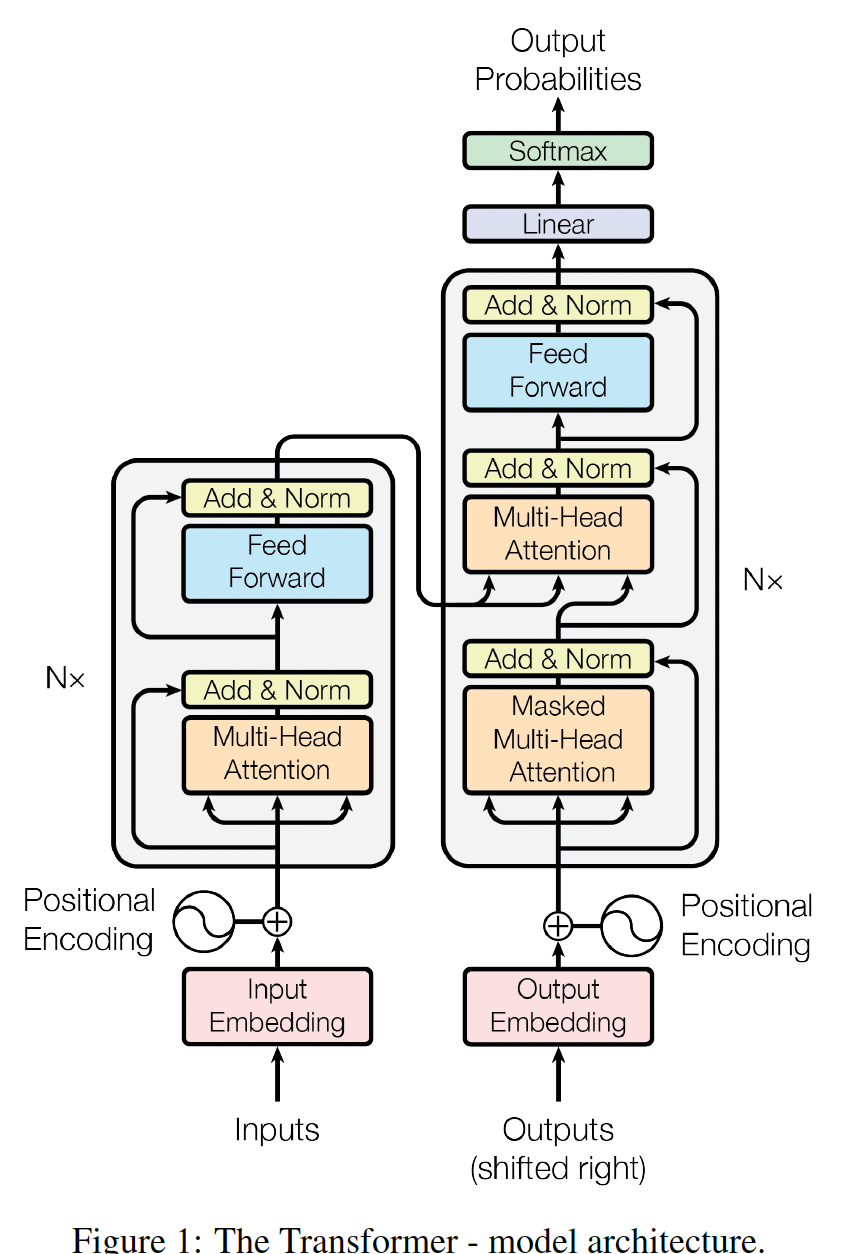


In [71]:
# Imports 
import torch
import torch.nn as nn

import math


#### Create Word Embeddings

In [65]:
# N : Vocab size --> 
# d_model = embedding dimension --> 512 (even number)
# n : sequence length --> 10
class Embedding(nn.Module):
    def __init__(self,N,d_model):
        super(Embedding,self).__init__()
        self.embd = nn.Embedding(N,d_model)
        
    def forward(self,x):
        return self.embd(x)
    
    

#### Positional Embedding

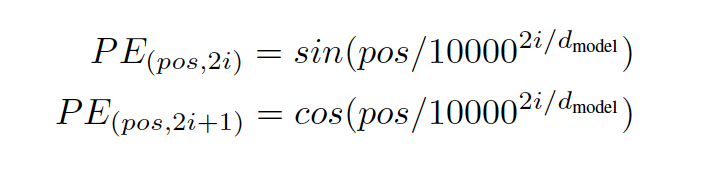




In [145]:
# i = postion in word in a sentence scaled b/w [0,1]
class PostionalEncoding(nn.Module):
    def __init__(self,n,d_model):
        
        super(PostionalEncoding,self).__init__()
        self.d_model = d_model
        pe = torch.zeros(n,d_model)
        for pos in range(n):
            for i in range(0,self.d_model,2):
                pe[pos,i] = math.sin(pos/(10000**(2*i/self.d_model)))
                pe[pos,i+1] = math.cos(pos/(10000**(2*i/self.d_model)))
        pe = pe.unsqueeze(0)  # batch size dim
        # If you have parameters in your model, which should be saved and restored in the state_dict,
        # but not trained by the optimizer, you should register them as buffers.
        self.register_buffer('pe',pe)
        
    
    def forward(self,x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False)
        return x

#### Self Attention
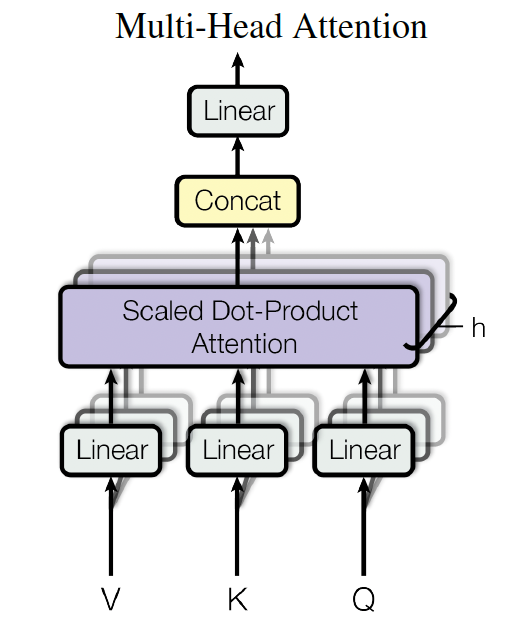

1. Suppose we have batch_size=32,sequence_length=10, embedding dimension=512. So after embedding and positional encoding our output will be of dimension 32x10x512.We will resize it to 32x10x8x64.(About 8, it is the number of heads in multihead attention.Dont worry you will get to know about it once you go through the code.)

2. Suppose our key,query and value dimension be 32x10x8x64. Before proceeding further, we will transpose each of them for multiplication convinience (32x8x10x64). Now multiply query matrix with transpose key matrix. ie (32x8x10x64) x (32x8x64x10) -> (32x8x10x10).ipynb_checkpoints/

3. we will divide 32x8x10x10 vector by 8 ie, by square root of 64 (dimension of key matrix)

4. our output will be of dimension 32x8x10x10. Now muliply it with value matrix (32x8x10x64) to get output of dimension (32x8x10x64).Here 8 is the number of attention heads and 10 is the sequence length.Thus for each word we have 64 dim vector.

5. (32x8x10x64) vector gets transposed to (32x10x8x64) and then reshaped as (32x10x512).Then it is passed through a linear layer to get output of (32x10x512)




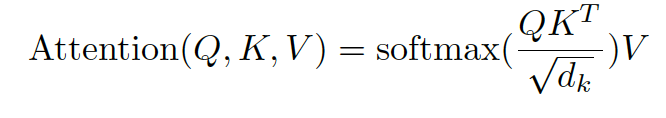

In [190]:
# Q:32,8,10,64 * K.T:32,8,64,10 ==> 32,8,10,10 * V:32,8,10,64 ==> Dot Product Attention :32,8,10,64 ->32,10,8,64 -> Concat : 32,10,512 --> Linear
class MultiheadAttention(nn.Module):
    def __init__(self,h,d_model):
        super(MultiheadAttention,self).__init__()
        
        self.h = h
        self.d_model = d_model
        assert d_model % h == 0
        self.d_k = self.d_model // self.h
        
        self.k = nn.Linear(self.d_k,self.d_k,bias=False)
        self.q = nn.Linear(self.d_k,self.d_k,bias=False)
        self.v = nn.Linear(self.d_k,self.d_k,bias=False)
        
        self.out = nn.Linear(self.d_model,self.d_model)
        
    def forward(self,q,k,v,mask=None):
        batch = q.shape[0]
        n = q.shape[1]
        q = q.view(batch,n,self.h,self.d_k).transpose(1,2) #32,8,10,64
        k = k.view(batch,n,self.h,self.d_k).transpose(1,2)
        v = v.view(batch,n,self.h,self.d_k).transpose(1,2)
        
        product = q @ k.transpose(-1,-2)
        
        # fill those positions of product matrix as (-1e20) where mask positions are 0
        if mask is not None:
            product = product.masked_fill(mask == 0, float("-1e20"))
        
        #divising by square root of key dimension
        product = product / math.sqrt(self.d_k)
        
        product = nn.functional.softmax(product,dim=-1)
        
        output = product @ v   # 32,8,10,10 * V:32,8,10,64
        
        concat = output.transpose(1,2).contiguous().view(batch,n,self.d_model)
        
        return self.out(concat)

#### Encoder 
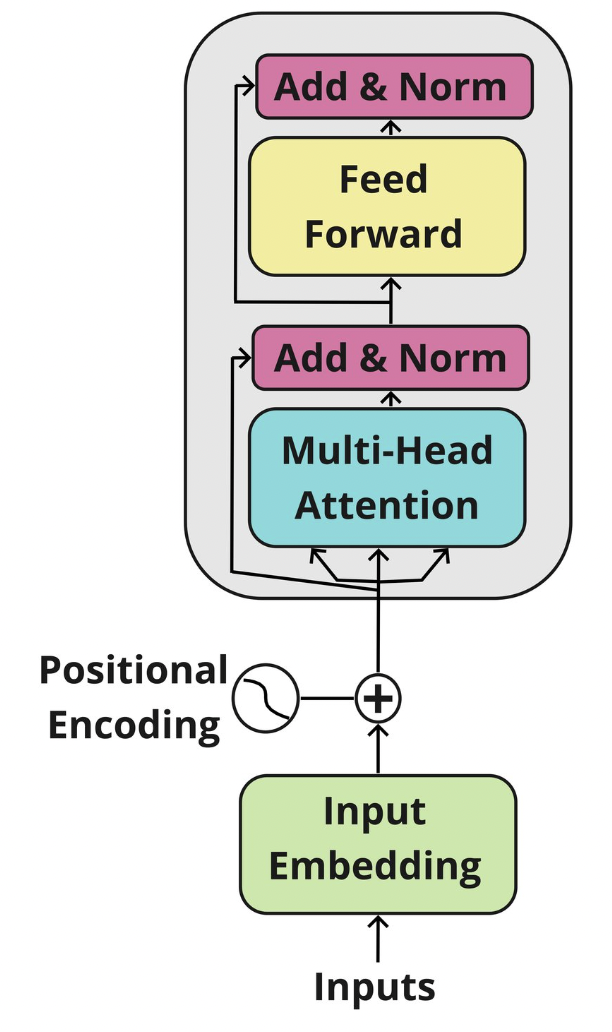

 output of multihead attention which is 32x10x512 gets added with 32x10x512 input(which is output created by embedding vector) and then the layer is normalized. This gets passed through 2 linear layers: 32x10x512 -> 32x10x2048 -> 32x10x512. Finally we have a residual connection which gets added with the output and the layer is normalized. Thus a 32x10x512 dimensional vector is created as output for the encoder.





In [200]:
class EncoderBlock(nn.Module):
    
    def __init__(self,h,d_model,factor=2):
        super(EncoderBlock,self).__init__()
        self.attention = MultiheadAttention(h,d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        
        self.fc = nn.Sequential(
                               nn.Linear(d_model,factor*d_model),
                               nn.ReLU(),
                               nn.Linear(factor*d_model,d_model)
                               )
        self.dropout = nn.Dropout(0.2)
        
    def forward(self,q,k,v):
        attention = self.attention(q,k,v)
        attention = self.layer_norm(q + attention)
        out = self.dropout(self.fc(attention))
        return self.layer_norm(attention + out)
        

In [201]:
class Encoder(nn.Module):
    
    def __init__(self,N,n,h,d_model,layers):
        super(Encoder,self).__init__()
        
        self.embedding = Embedding(N,d_model)
        self.positional_encoder = PostionalEncoding(n,d_model)

        self.layers = nn.ModuleList([EncoderBlock(h,d_model) for _ in range(layers)])
        
        
    def forward(self,x):
        embedding = self.embedding(x)
        positional_encoder = self.positional_encoder(embedding)
        out = embedding + positional_encoder

        for layer in self.layers:
            out = layer(out,out,out)
        
        return out
        
        

In [202]:
## Test encoder 
x= torch.randint(0,1000,(32,10))
encoder = Encoder(1000,10,8,512,4)
encoder(x).shape

torch.Size([32, 10, 512])

#### Decoder 
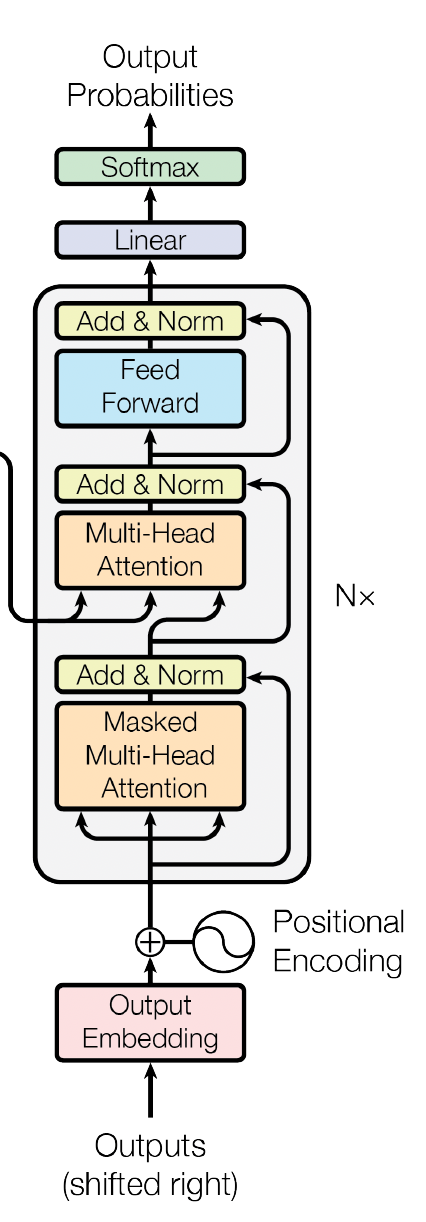

In [203]:

class DecoderBlock(nn.Module):
    def __init__(self,h,d_model,factor= 4):
        super(DecoderBlock,self).__init__()
        
        self.attention = MultiheadAttention(h,d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        
        self.feed_forward = nn.Sequential(nn.Linear(d_model,factor* d_model),
                                         nn.ReLU(),
                                         nn.Linear(factor* d_model,d_model))
        
        
    def forward(self,x,enc_out,target_mask):
        masked_headed_attnetion = self.attention(x,x,x,target_mask)
        value = self.layer_norma(masked_headed_attnetion + k)
        
#         source key & source query = enc_out
        cross_attention = self.attention(enc_out,enc_out,value)
        cross_attention = self.layer_norm(cross_attention + value)

        out = self.feed_forward(cross_attention)
        
        out = self.layer_norma(cross_attention+out)
        
        return out
        
    
class Decoder(nn.Module):
    def __init__(self,N,n,h,d_model,enc_layers,dec_layers):
        super(Decoder,self).__init__()
        
        self.embedding = Embedding(N,d_model)
        self.pos_encoding = PostionalEncoding(n,d_model)
        self.encoder = Encoder(N, n, h, d_model, enc_layers)
        self.layers = nn.ModuleList([DecoderBlock(h,d_model) for _ in range(layers)])
        
    def forward(self,src,target):
        
#       src,target --> 32,10
        embedding = self.embedding(target)
        pos_encoding = self.pos_encoding(target)
        embeddings = embedding + pos_encoding # 32,10,512
        
        enc_out = self.encoder(src)
        
        for layer in self.layers:
            out = layer(embeddings,enc_out,target_mask)
    

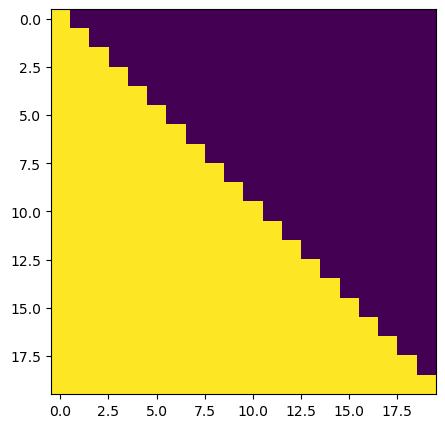

In [206]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

In [ ]:
## TODO : How to apply this mask vector to the attention vectors ?
